## Assignment 12

In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as ss
import pandas as pd
import numpy as np
import seaborn as sns

np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges
bottom = 0;
top = len(xvals);
right = 0;
left = len(yvals);
for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    bottom = max(bottom, np.argmax(xhist>0.5))
    top = min(top, len(xvals)-np.argmax(xhist[::-1]>0.5))
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    right = max(right, np.argmax(yhist>0.5))
    left = min(left, len(yvals)-np.argmax(yhist[::-1]>0.5))

# Copy new dataset without edges
df2 = df.copy()
for z in zvals:
    df2.drop(df2.index[(df2['cx']<xvals[bottom]) | (df2['cx']>=xvals[top])], inplace=True)
    df2.drop(df2.index[(df2['cy']<yvals[right]) | (df2['cy']>=yvals[left])], inplace=True)

xvals = df2['cx'].unique()
yvals = df2['cy'].unique()
zvals = df2['cz'].unique()

df2.head()

,cx,cy,cz,unmasked,synapses,weighted
6292,448,1369,55,126357,153,238.063772
6293,448,1369,166,139932,207,290.840237
6294,448,1369,277,150269,194,253.824488
6295,448,1369,388,138071,159,226.410122
6296,448,1369,499,150842,258,336.278119


### Linear trends in X, Y, and Z

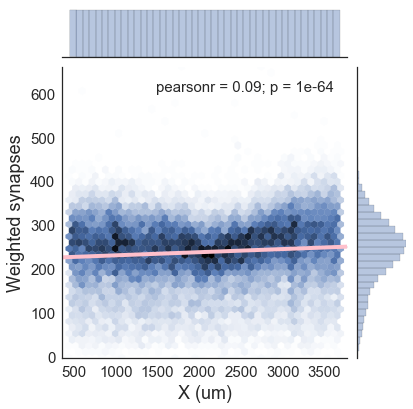

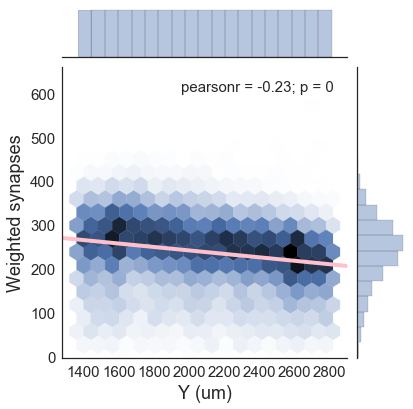

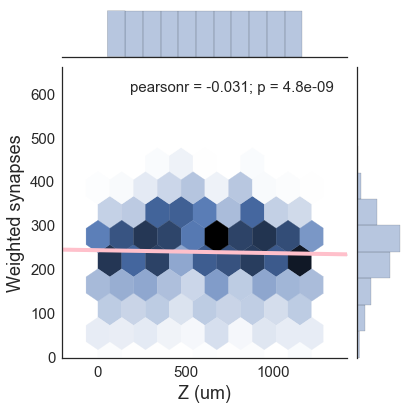

In [2]:
fs = 18

bottom = df2['weighted'].min()
top = df2['weighted'].max()

sns.set_style('white')

avals_list = [xvals, yvals, zvals]
anames = ['cx', 'cy', 'cz']
alabels = ['X (um)', 'Y (um)', 'Z (um)']
ascales = [2, 2, 1]

for avals, aname, alabel, ascale in zip(avals_list, anames, alabels, ascales):
    delta = 2*(avals[1]-avals[0])
    extra = delta / (np.sqrt(3)/2)
    left = np.min(avals) - extra
    right = np.max(avals) + extra

    with sns.plotting_context('notebook', font_scale=1.5):
        g = sns.jointplot(x=aname, y='weighted', data = df2, kind='hex',
                          joint_kws={'gridsize':len(avals)/ascale+1, 'extent':(left, right, bottom, top)},
                          marginal_kws={'bins':len(avals)/ascale})
        g = g.plot_joint(sns.regplot, scatter=False, color='pink', line_kws={'linewidth': 4})
        sns.axlabel(alabel, 'Weighted synapses', fontsize=fs)

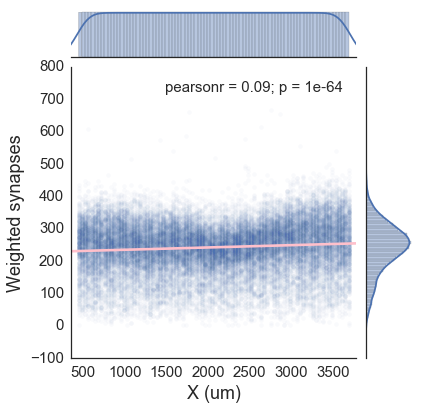

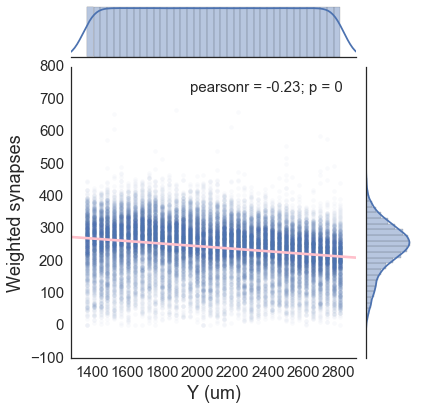

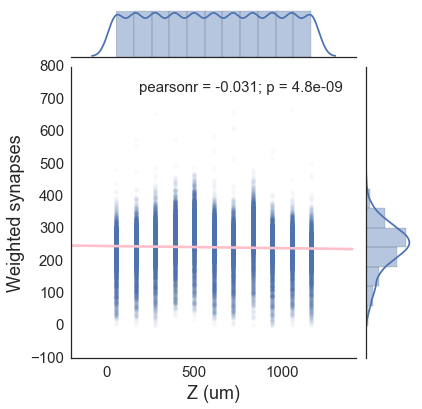

In [3]:
fs = 18

sns.set_style('white')

avals_list = [xvals, yvals, zvals]
anames = ['cx', 'cy', 'cz']
alabels = ['X (um)', 'Y (um)', 'Z (um)']

for avals, aname, alabel in zip(avals_list, anames, alabels):
    delta = 2*(avals[1]-avals[0])
    extra = delta / (np.sqrt(3)/2)
    left = np.min(avals) - extra
    right = np.max(avals) + extra

    with sns.plotting_context('notebook', font_scale=1.5):
        g = sns.jointplot(x=aname, y='weighted', data = df2, kind='reg',
                          scatter_kws={'alpha':0.03}, 
                          line_kws={'color':'pink'}, 
                          marginal_kws={'bins':len(avals)})
        plt.xlim([left, right])
        sns.axlabel(alabel, 'Weighted synapses', fontsize=fs)

### Plotting distribution of clustered groups

In [4]:
from sklearn.cluster import KMeans

optn = 6

est = KMeans(n_clusters = optn)
est.fit(df2['weighted'].reshape(-1,1))
labels = est.labels_
df2['label'] = labels

# Sort groups by means
groups = np.sort(df2['label'].unique())

means = np.array([df2.loc[df2['label']==label,'weighted'].mean() for label in groups])
reindex = np.argsort(means)

new_labels = np.array(labels)

for label in groups:
    new_labels[labels==label] = np.argmax(reindex==label)

df2['label'] = new_labels

means = np.array([df2.loc[df2['label']==label,'weighted'].mean() for label in groups])
print means
counts = np.array([df2.loc[df2['label']==label,'weighted'].count() for label in groups])
print counts

df2.head()

[  78.64772033  152.23364054  210.28886914  256.09104499  302.3356006
  363.69382481]
[2461 4144 7684 9788 7822 3213]


,cx,cy,cz,unmasked,synapses,weighted,label
6292,448,1369,55,126357,153,238.063772,3
6293,448,1369,166,139932,207,290.840237,4
6294,448,1369,277,150269,194,253.824488,3
6295,448,1369,388,138071,159,226.410122,2
6296,448,1369,499,150842,258,336.278119,5


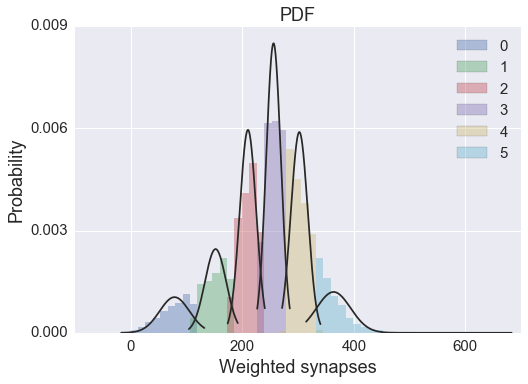

In [5]:
# Plot distributions of our dataset
from scipy.stats import norm

priors = np.array([np.float(count)/np.sum(counts) for count in counts])
# print groups, priors

sns.set_style('darkgrid')

_, bin_edges = np.histogram(df2['weighted'], bins=50)

fs = 18

with sns.plotting_context('notebook', font_scale=1.5):
    plt.figure()
    for label, prior in zip(groups, priors):
        g = sns.distplot(df2[df2['label']==label]['weighted'], bins=bin_edges, kde=False, fit=norm, 
                         label=str(label), hist_kws={'edgecolor': 'none'})

    # weight fit by priors
    for label, prior in zip(groups, priors):
        fit = (plt.gca().lines[label].get_data()[0], prior*plt.gca().lines[label].get_data()[1])
        plt.gca().lines[label].set_data(fit)

    # weight histograms by priors
    scale = -1
    for i in plt.gca().patches:
        lstr = i.get_label()
        if len(lstr)==1:
            label = int(i.get_label())
            scale = priors[label]
        if scale != -1:
            h = i.get_height()
            i.set_height(scale*h)

    plt.gca().set_ylim(0,0.009)
    plt.xlabel('Weighted synapses', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.title('PDF', fontsize=fs)
    plt.legend()
    plt.xticks(np.arange(0,700,200))
    plt.yticks(np.arange(0,0.01,0.003))
    plt.show()

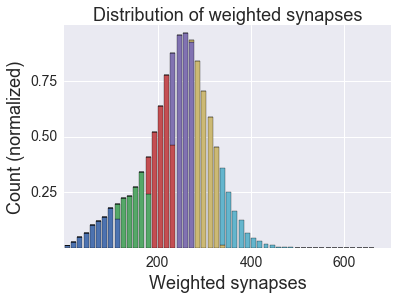

In [6]:
from matplotlib import ticker

fs = 18
tfs = 14

with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.PairGrid(df2, hue='label', vars=['weighted'])
    g = g.map_diag(plt.hist, bins=50)
#     g = g.map_offdiag(plt.scatter)
    plt.gcf().axes[0].set_xlabel('Weighted synapses', fontsize=fs)
    plt.gcf().axes[0].set_ylabel('Count (normalized)', fontsize=fs)
    
    for ax in g.axes.flat:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4, prune="both"))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(4, prune="both"))

        ax.tick_params(axis='both', which='major', labelsize=tfs)
    
    plt.gcf().set_size_inches(10,6)
    plt.title('Distribution of weighted synapses')
    plt.show()